## Classifying songs as hits or flops based on Spotify's track data

This dataset is downloaded from Keggle.

Shout out to @ALBERT ANGKASA for the wonderful dataset https://www.kaggle.com/code/albertangkasa/spotify-bop-or-flop/data.


The objective of this analysis is to answer the below questions?


1. Identify what features are significant to distinguiush "hit" from a "flop"?
2. Do the features define a "hit" change over time (from decade to decade)?
3. Can Spotify use this data to predict whether a song going to be a hit or a flop by analyzing it's meta data? 

In [3]:
import pandas as pd
import numpy as np
import difflib #find closests string matches
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pingouin import kruskal
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [4]:
import glob
import os

#Read all files into a single dataframe

file_list = glob.glob("*.csv")

df =[]

for f in file_list:
    df_tmp = pd.read_csv(f)
    decade_part = f.split("-")[2].split(".")[0].replace('s','')
    if decade_part == '00':
        decade='2000'
    elif  decade_part == '10':
        decade='2010'
    else:
        decade='19'+decade_part
    
    df_tmp['decade'] = int(decade)
    df.append(df_tmp)

#pd.read_csv("dataset-of-00s.csv")

In [5]:
df = pd.concat(df, ignore_index=True)
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Misty Roses,Astrud Gilberto,spotify:track:50RBM1j1Dw7WYmsGsWg9Tm,0.527,0.316,1,-15.769,1,0.0310,0.693000,0.00699,0.1680,0.543,116.211,158840,4,53.89523,6,0,1990
1,Never Ever,All Saints,spotify:track:5FTz9qQ94PyUHETyAyfYZN,0.738,0.541,1,-5.485,1,0.0311,0.559000,0.00000,0.0492,0.309,134.187,387573,4,32.16853,16,1,1990
2,Soul Sermon,Gregg Karukas,spotify:track:6m24oe3lk1UMxq9zq4iPFi,0.736,0.419,0,-10.662,1,0.0300,0.693000,0.49500,0.0809,0.265,93.982,237267,4,42.05369,9,0,1990
3,Clarinet Marmalade - Live,Alton Purnell,spotify:track:5FOXuiLI6knVtgMUjWKj6x,0.565,0.594,5,-13.086,1,0.0646,0.655000,0.92600,0.6750,0.763,114.219,375933,4,80.99693,10,0,1990
4,До смерті і довше - Drum & Base and Rock Remix,Skryabin,spotify:track:6CxyIPTqSPvAPXfrIZczs4,0.513,0.760,4,-10.077,1,0.0355,0.000017,0.00339,0.1530,0.961,153.166,430653,4,25.57331,20,0,1990


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41106 non-null  object 
 1   artist            41106 non-null  object 
 2   uri               41106 non-null  object 
 3   danceability      41106 non-null  float64
 4   energy            41106 non-null  float64
 5   key               41106 non-null  int64  
 6   loudness          41106 non-null  float64
 7   mode              41106 non-null  int64  
 8   speechiness       41106 non-null  float64
 9   acousticness      41106 non-null  float64
 10  instrumentalness  41106 non-null  float64
 11  liveness          41106 non-null  float64
 12  valence           41106 non-null  float64
 13  tempo             41106 non-null  float64
 14  duration_ms       41106 non-null  int64  
 15  time_signature    41106 non-null  int64  
 16  chorus_hit        41106 non-null  float6

In [185]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000,1982.775264
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006,17.491234
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000,1960.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599792,8.000000,0.000000,1970.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000,1980.000000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000,2000.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000,2010.000000


In [186]:
df.shape

(41106, 20)

No null values and the data types are also correct.

In [6]:
df.drop(columns=['uri'], inplace=True)
# 
# cols = df.columns
# 
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# 
# df[0:15] = pd.DataFrame(sc.fit_transform(df[0:15]))
# 
df.to_csv("agg_data/spotify_tracks.csv")

### Class balance

In [188]:
df.groupby(['decade','target']).count().iloc[:,0]

decade  target
1960    0         4321
        1         4321
1970    0         3883
        1         3883
1980    0         3454
        1         3454
1990    0         2760
        1         2760
2000    0         2936
        1         2936
2010    0         3199
        1         3199
Name: track, dtype: int64

Both classes have equal number of entries representing each decade. Which means we do not need to balance the classes seperately.

In [189]:
col_list = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections' ]

### EDA

#### Let's first see how are the different features vary based on which decade those songs belong to?

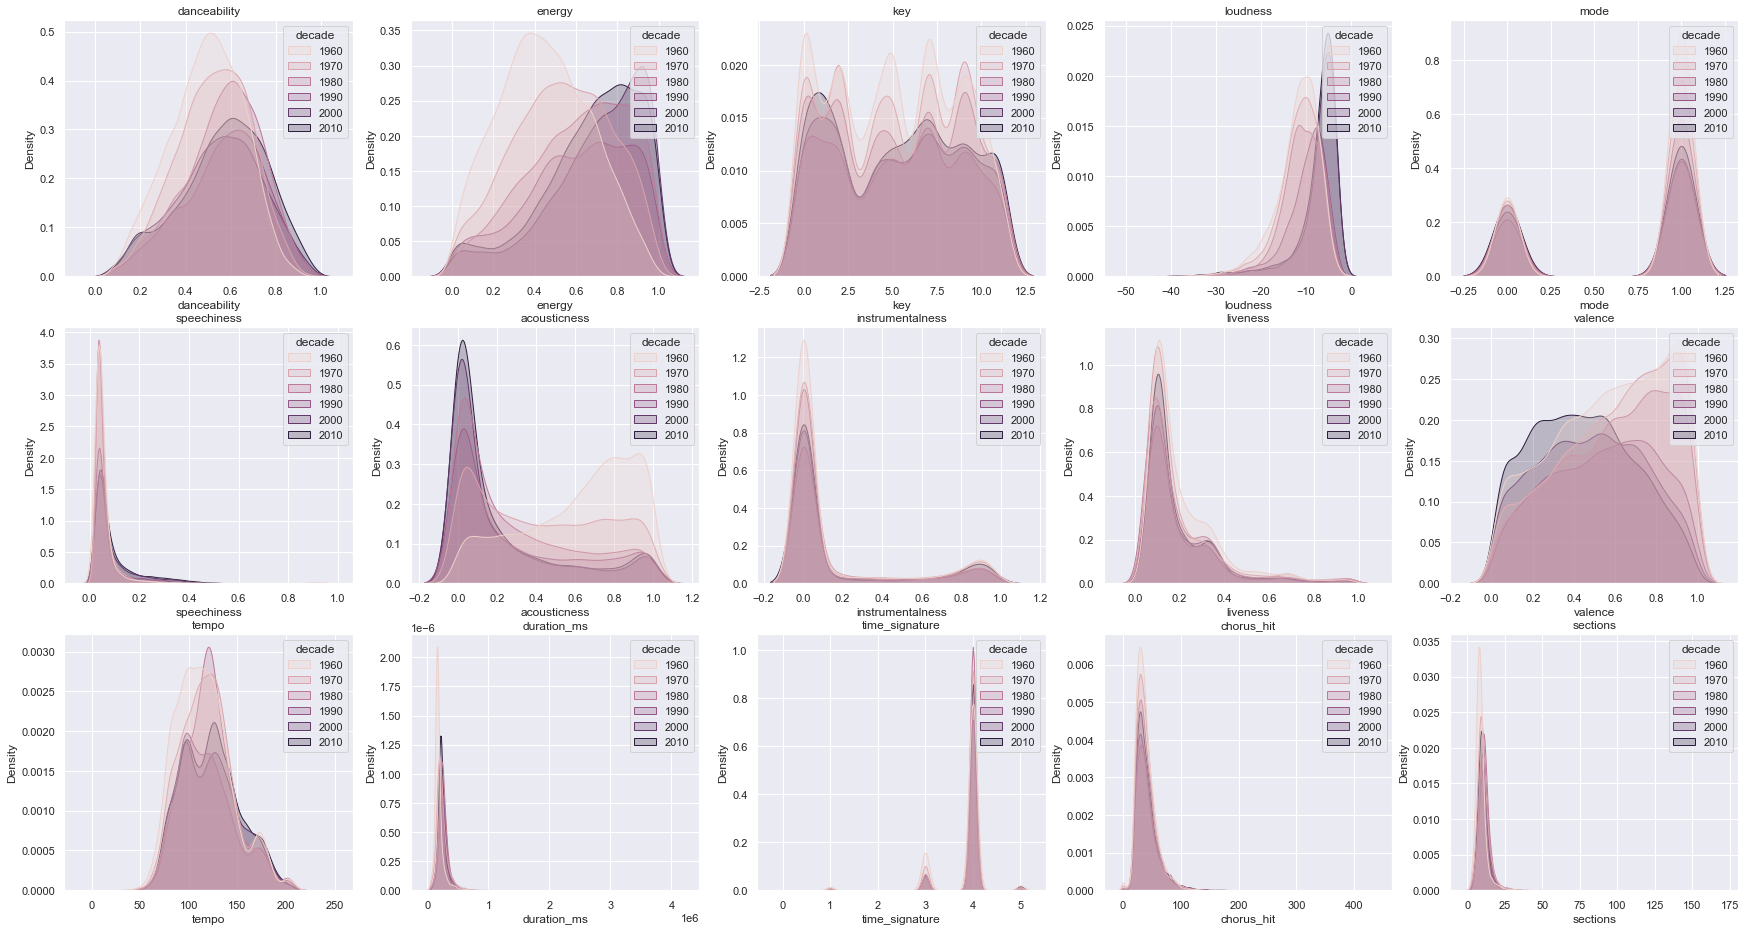

In [190]:
sns.set(rc = {'figure.figsize':(30,16)})
fig, axes = plt.subplots(3, 5)

#fig.suptitle('How features change in each decade')

col_idx = 0

for idx, col in enumerate(col_list):

    if idx<=4:
        sns.kdeplot(ax=axes[0,idx], data=df, x=col, hue='decade', fill=True).set_title(col)

    elif idx<=9:
        if idx==5:
            col_idx=0
        sns.kdeplot(ax=axes[1,col_idx], data=df, x=col, hue='decade', fill=True).set_title(col)
        col_idx += 1

    elif idx<=14:
        if idx==10:
            col_idx=0
        sns.kdeplot(ax=axes[2,col_idx], data=df, x=col, hue='decade', fill=True).set_title(col)
        col_idx += 1


In [191]:
df_m = df.groupby('decade').mean().reset_index()

In [192]:
df_m

,decade,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,1960,0.492169,0.445210,5.076487,-12.029726,0.755612,0.062402,0.615557,0.149919,0.213531,0.574963,115.125274,183638.344133,3.816593,38.938212,8.884286,0.5
1,1970,0.525500,0.527952,5.208344,-11.734270,0.721993,0.062053,0.434240,0.162163,0.199794,0.595993,119.009447,239933.116405,3.883981,39.847828,10.761010,0.5
2,1980,0.564258,0.608037,5.233353,-11.041894,0.687609,0.057906,0.293067,0.139863,0.201009,0.587922,120.649572,254756.410394,3.926317,39.755172,11.277649,0.5
3,1990,0.566893,0.602246,5.263043,-10.235112,0.669565,0.073996,0.291220,0.159886,0.197202,0.537685,118.840424,256210.994022,3.922464,40.999358,11.128261,0.5
4,2000,0.542931,0.694511,5.276396,-7.449258,0.645095,0.092360,0.214374,0.150917,0.196141,0.482262,121.613018,258170.628236,3.913999,40.734295,11.056880,0.5
5,2010,0.568163,0.667756,5.283526,-7.589796,0.645514,0.098018,0.216928,0.165293,0.196700,0.443734,122.353871,236704.210378,3.930916,41.028399,10.316505,0.5


We can clearly notice that some features have evolve as the decades go by.

1. The mean of the danceability, energy, key, loudness, mode, and acousticnes has gradually increased from 1960.

#### Let's first see how are the different features vary based on the target value?

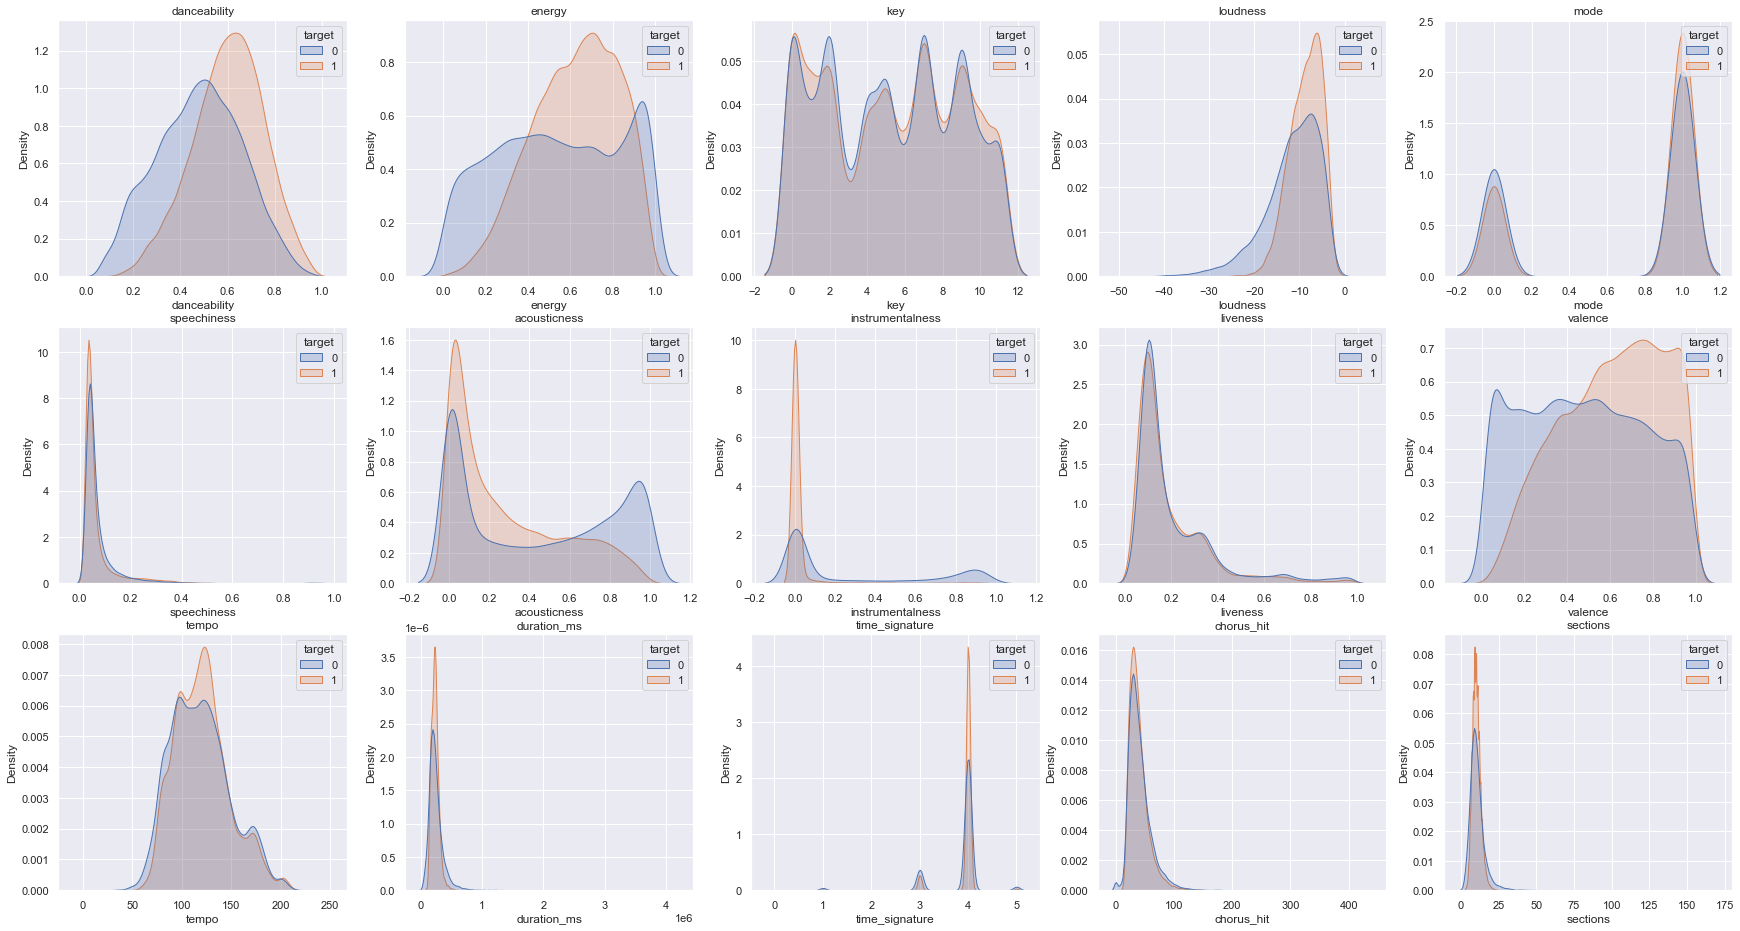

In [193]:
sns.set(rc = {'figure.figsize':(30,16)})
fig, axes = plt.subplots(3, 5)
#fig.suptitle('How features change in each decade')

col_idx = 0

for idx, col in enumerate(col_list):

    if idx<=4:
        sns.kdeplot(ax=axes[0,idx], data=df, x=col, hue='target', fill=True).set_title(col)

    elif idx<=9:
        if idx==5:
            col_idx=0
        sns.kdeplot(ax=axes[1,col_idx], data=df, x=col, hue='target', fill=True).set_title(col)
        col_idx += 1

    elif idx<=14:
        if idx==10:
            col_idx=0
        sns.kdeplot(ax=axes[2,col_idx], data=df, x=col, hue='target', fill=True).set_title(col)
        col_idx += 1


In [194]:
df_new = df.iloc[:,2:]

### Training, validation, and test data split

In [195]:
X= df_new[list(df_new.columns[df_new.columns!='target']) ]
y= df_new['target']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train validation split
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)

In [196]:
print("Training data size : {}, Test data size {} ".format(X_train.shape, X_test.shape))

Training data size : (32884, 16), Test data size (8222, 16) 


### Feature importance

<AxesSubplot:>

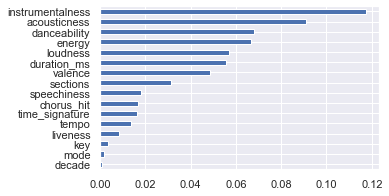

In [197]:
#information gain. mutual info

from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info, X_train.columns).sort_values()

sns.set(rc = {'figure.figsize':(5,3)})
mutual_info.plot(kind='barh')

We can note that key and decade variable has a very weak relationship with the target variable.

<AxesSubplot:>

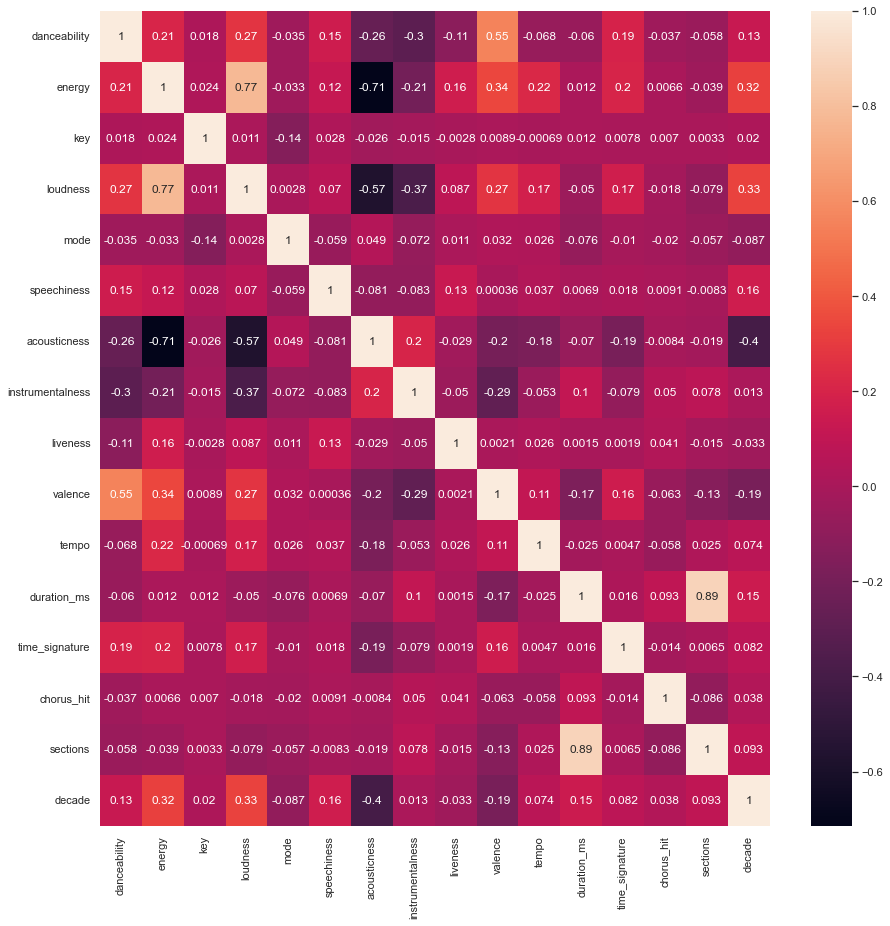

In [198]:
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(X_train.corr(),annot=True)

The below features have a strong positive correlation (correlation > 0.5).
- danceability vs valence (0.55)
- energy vs loudness (0.77)
- duration_ms vs sections (0.89)

The below features have a strong negative correlation (correlation > -0.5).
- energy vs acousticness (-0.72)
- energy vs loudness (-0.57)

- We decide to drop the key and decade variables due to their weak association with the target variable. 
- And also we drop highly correlated independent variables (multicollinearity). For this we select any pair of variables with absolute correlation value > 0.8.
    - We can see that duration_ms and sections has a correlation co-efficent of 0.89. Hence, we should drop one. 
    - Out of the aforemnetioned variables we drop the one that accounts for the minimum amount of mutual information shared with the target variable. Hence, we drop sections.


In [199]:
df.columns

Index(['track', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'target', 'decade'],
      dtype='object')

#### 1. Identify what feature combinations can be used to distinguiush "hit" from a "flop"?
Based on the mutual information measure we can identify that instrumentalness, acousticness, danceability, energy, and loudness as the top 5 features.

#### 2. Do the features define a "hit" or "flop" change over time (from decade to decade)?

In [200]:
df_hit = df[df['target']==1].groupby('decade').mean().reset_index()

In [201]:
df_flop = df[df['target']==0].groupby('decade').mean().reset_index()

Text(0.5, 1.0, 'loudness')

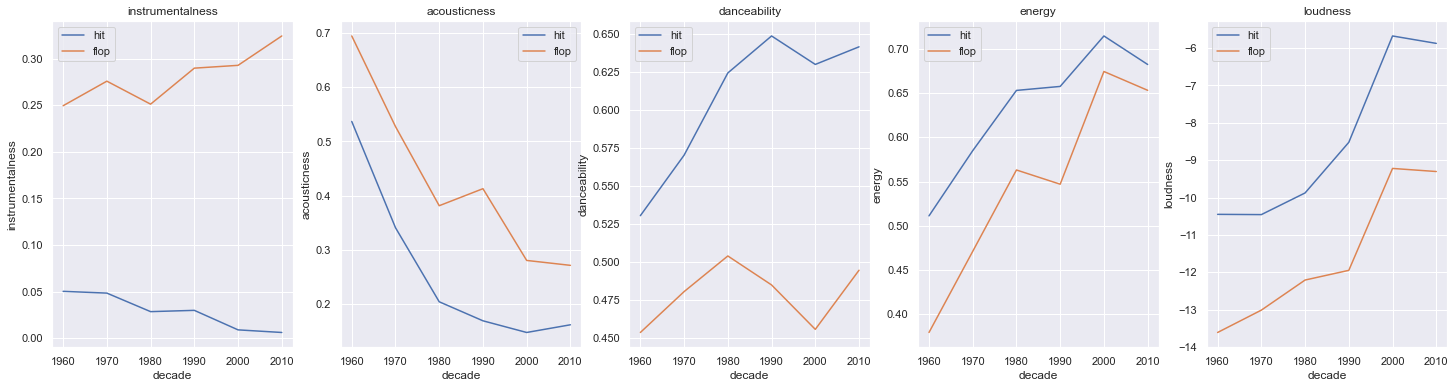

In [202]:
sns.set(rc = {'figure.figsize':(25,6)})

fig, axes = plt.subplots(1, 5)
sns.lineplot(ax=axes[0], data=df_hit, x='decade', y='instrumentalness', label='hit').set_title('instrumentalness')
sns.lineplot(ax=axes[0], data=df_flop, x='decade', y='instrumentalness',label='flop').set_title('instrumentalness')

sns.lineplot(ax=axes[1], data=df_hit, x='decade', y='acousticness', label='hit').set_title('acousticness')
sns.lineplot(ax=axes[1], data=df_flop, x='decade', y='acousticness',label='flop').set_title('acousticness')

sns.lineplot(ax=axes[2], data=df_hit, x='decade', y='danceability', label='hit').set_title('danceability')
sns.lineplot(ax=axes[2], data=df_flop, x='decade', y='danceability',label='flop').set_title('danceability')

sns.lineplot(ax=axes[3], data=df_hit, x='decade', y='energy', label='hit').set_title('energy')
sns.lineplot(ax=axes[3], data=df_flop, x='decade', y='energy',label='flop').set_title('energy')

sns.lineplot(ax=axes[4], data=df_hit, x='decade', y='loudness', label='hit').set_title('loudness')
sns.lineplot(ax=axes[4], data=df_flop, x='decade', y='loudness',label='flop').set_title('loudness')




##### From the above depictions we can notice that how the top 5 features have changed over the decades. 
- While the average instrumentalness for hit songs have dropped over the decades that of the flop songs have gradually increased.
- Acousticness for hit and flop songs have gradually dropped over the decades. However, the acousticness of the hit songs are less than that of the flop songs.
- When considering danceability, hit songs report a high value compared to the flop songs across all the decades. Danceability has increased for hit songs consistantly from 60s to till 90s.
- Hit songs reportedly have more energy compared to flop songs. However, for both hits and flops energy has increased over the decades.
- Loudness has increased for both hits and flops over the years whereas hits reportedly are louder than flops.

In [203]:
X_train.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade'],
      dtype='object')

In [204]:
to_drop= ['sections','decade']
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)
#X_validation.drop(columns=to_drop, inplace=True)

In [205]:
#Training data stats for standardization
train_means = X_train.mean(axis=0)
train_sds = X_train.std(axis=0)

stat_dict = dict.fromkeys(X_train.columns)
for key in stat_dict.keys():
    stat_dict[key] = [train_means[key].astype(float), train_sds[key].astype(float)]

In [206]:
X_train.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit'],
      dtype='object')

### Data standardization

In [207]:
col_list = X_train.columns
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train))
X_train.columns = col_list

for col in X_test:
    stats = stat_dict[col]
    mean = stats[0]
    sd = stats[1]
    X_test[col] = (X_test[col]-mean)/sd


### Inital model training

In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier



In [209]:
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.05, n_estimators=100,random_state=42)
    }

for name, model in models.items():
    model.fit(X_train, y_train)
    cv_accuracy = np.mean(cross_val_score(model, X_train, y_train, cv=5))

    test_acc = model.score(X_test, y_test)
    print(name, " Training accuracy : ", cv_accuracy, " Test accuracy : ", test_acc)


Decision Tree  Training accuracy :  0.751307628663924  Test accuracy :  0.7579664315251764
Random Forest  Training accuracy :  0.7594574351672329  Test accuracy :  0.7617368036973973
Gradient Boosting  Training accuracy :  0.772412187535491  Test accuracy :  0.7752371685721235


### Model selection

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required to decide a leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf' : min_samples_leaf,
               'bootstrap': bootstrap
               }



# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, scoring='accuracy', verbose=2)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [211]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 500}

In [212]:
rf = RandomForestClassifier(n_estimators= 500,
 min_samples_split= 5,
 min_samples_leaf= 2,
 max_features= 'sqrt',
 max_depth= None,
 bootstrap= True)

rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300)

In [213]:
y_pred = rf.predict(X_test)

In [214]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")



Accuracy : 0.7882510338117247
Precision : 0.7551648351648351
Recall : 0.8456805316268767
F1 : 0.7978636944154186


As we can observe the accuracy, precision, recall, and F1 score all have improved.

In [215]:
import joblib
import pickle

#Python Pickle module is used for serializing and de-serializing Python object structures(list, dict, etc.) into byte streams (0s and 1s). 
pickle_out = open("rf_predictor.pkl", "wb")
pickle.dump(rf, pickle_out)
pickle_out.close()


In [ ]:
#save to a json file
import json
with open("mean_sd.json", "w") as outfile:
    json.dump(stat_dict, outfile)
